In [2]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math
import vk
import settings
import time

session = vk.AuthSession(settings.vk_auth['id_app'], settings.vk_auth['login'], settings.vk_auth['password'])
vk_api = vk.API(session, v='5.85', timeout=10)

%matplotlib inline
pd.set_option('display.max_columns', 500)

In [3]:
#logger
#TODO дополнительно писать лог в файл
#Вывести в отдельный модуль
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
    
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)
    
    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [4]:
#определяем название выходного файла для заведений
places_out_file = 'vk_places_spb.csv'

places_out_geo_file = 'vk_places_spb.geojson'

#определяем название выходного файла для чекинов
checkins_out_file = 'vk_checkins_spb.csv'

#определяем название выходного файла для пользователей в округе
users_field_out_file = 'vk_users_field_spn.csv'

#вых файл для пользователей по чекинам в заведениях
users_field_out_file = 'vk_users_in_places_spb.csv'

#определяем название выходного файла для социального графа
friends_out_file = 'friends_fn.csv'

In [5]:
#Папки
raw_data = '../Data/RawData/'
processing_data = '../Data/ProcessingData/'
result_data = '../Data/CleanData/'

In [5]:
places_18_df = pd.read_csv('../Data/RawData/all_places.csv', encoding='windows-1251')
places_19_df = pd.read_csv(processing_data + places_out_file)
#checkins_df = pd.read_csv('../Data/RawData/all_checkins.csv', encoding='windows-1251')

In [8]:
#кол-во заведений
places_18_df.shape[0]

62906

In [9]:
places_19_df.shape[0]

46314

In [11]:
places_19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46314 entries, 0 to 46313
Data columns (total 12 columns):
Unnamed: 0    46314 non-null int64
address       46314 non-null object
checkins      46314 non-null int64
city          46314 non-null int64
country       46314 non-null int64
created       46314 non-null int64
distance      46314 non-null int64
id            46314 non-null int64
lat           46314 non-null float64
lng           46314 non-null float64
title         46314 non-null object
type          46314 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.2+ MB


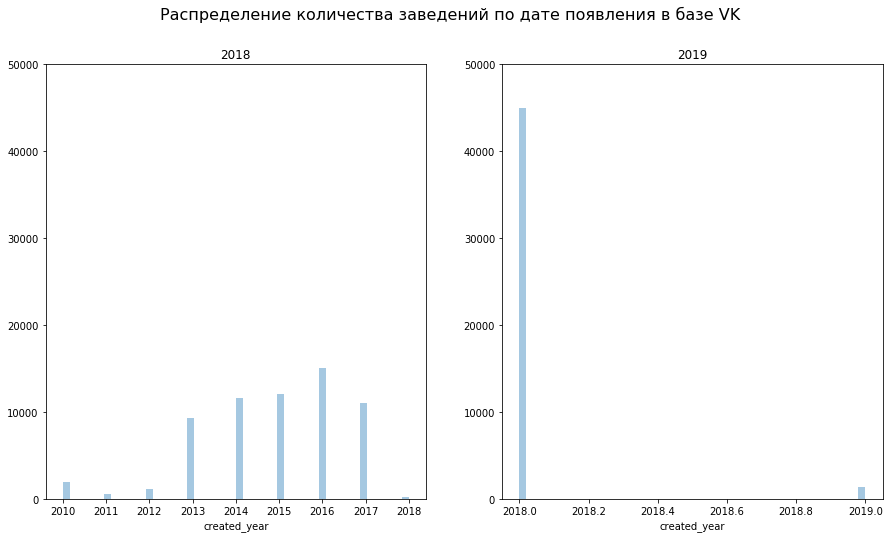

In [26]:
#распределение по году создания 19 год
fig, ax = plt.subplots(1,2, figsize=(15,8))
fig.suptitle('Распределение количества заведений по дате появления в базе VK', fontsize=16)
ax[0].set_title('2018')
ax[0].set_ylim(top=50000)
places_18_df['created_year'] = places_18_df.created.apply(lambda d: int(datetime.utcfromtimestamp(d).strftime('%Y')))
sns.distplot(places_18_df.created_year, kde=False,ax=ax[0])
ax[1].set_title('2019')
ax[1].set_ylim(top=50000)
places_19_df['created_year'] = places_19_df.created.apply(lambda d: int(datetime.utcfromtimestamp(d).strftime('%Y')))
sns.distplot(places_19_df.created_year, kde=False, ax=ax[1])

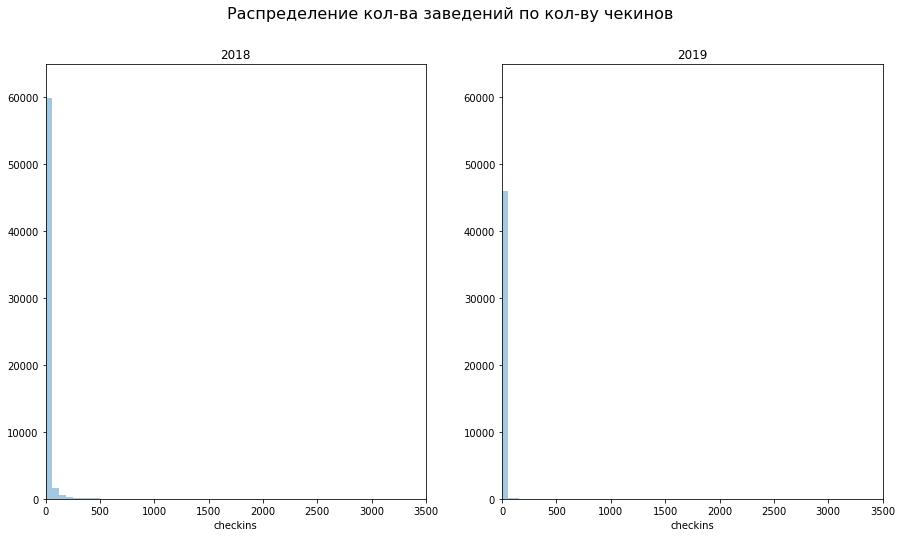

In [31]:
#распределение кол-ва чекинов
fig, ax = plt.subplots(1,2, figsize=(15,8))
fig.suptitle('Распределение кол-ва заведений по кол-ву чекинов', fontsize=16)
ax[0].set_title('2018')
ax[0].set_ylim(top=65000)
ax[0].set_xlim(right=3500)
sns.distplot(places_18_df.checkins, kde=False, ax = ax[0])
ax[1].set_title('2019')
ax[1].set_ylim(top=65000)
ax[1].set_xlim(right=3500)
sns.distplot(places_19_df.checkins, kde=False, ax = ax[1])

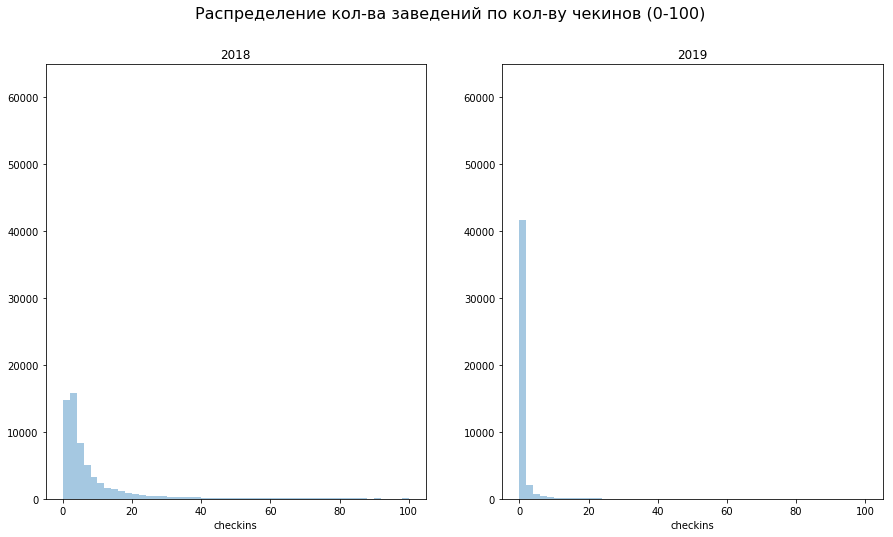

In [36]:
#распределение кол-ва чекинов
fig, ax = plt.subplots(1,2, figsize=(15,8))
fig.suptitle('Распределение кол-ва заведений по кол-ву чекинов (0-100)', fontsize=16)
ax[0].set_title('2018')
ax[0].set_ylim(top=65000)
#ax[0].set_xlim(right=100)
sns.distplot(places_18_df[places_18_df['checkins'] <= 100].checkins, kde=False, ax = ax[0])
ax[1].set_title('2019')
ax[1].set_ylim(top=65000)
#ax[1].set_xlim(right=100)
sns.distplot(places_19_df[places_19_df['checkins'] <= 100].checkins, kde=False, ax = ax[1])

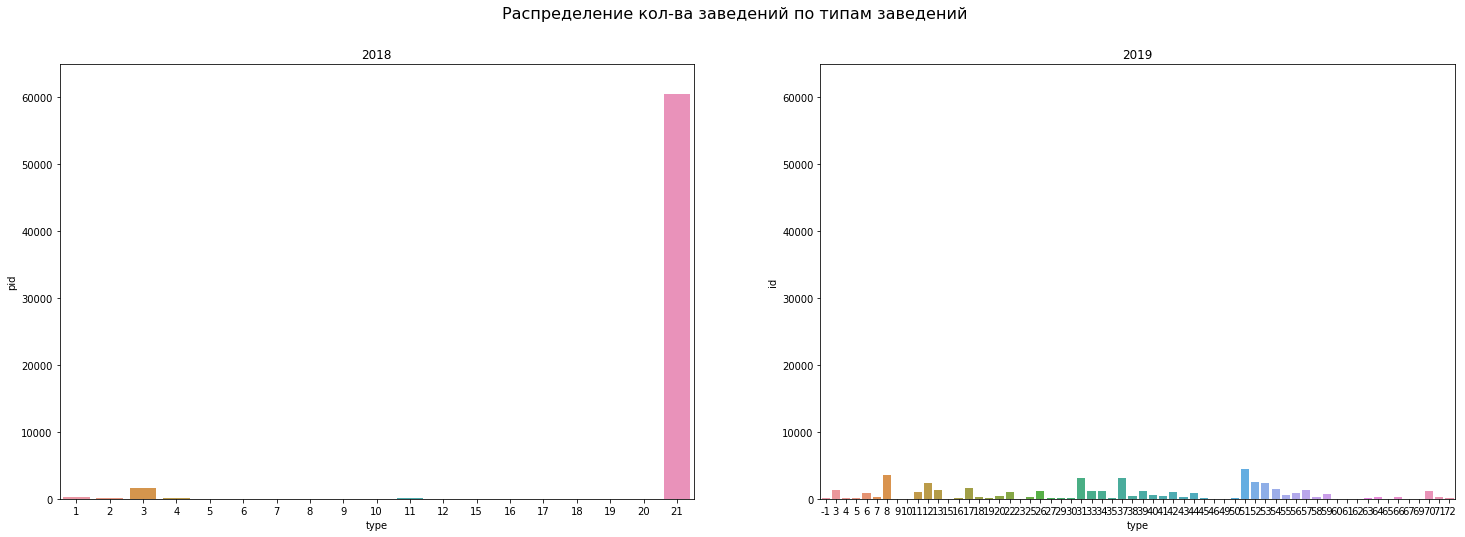

In [81]:
#распределение заведений по типам
fig, ax = plt.subplots(1,2, figsize=(25,8))
fig.suptitle('Распределение кол-ва заведений по типам заведений', fontsize=16)
ax[0].set_title('2018')
ax[0].set_ylim(top=65000)
ax[0].set_xlim(right=72)
places_18_groupby_type = places_18_df.groupby('type')['pid'].count().reset_index()
sns.barplot(x='type', y='pid', data=places_18_groupby_type, ax=ax[0])

ax[1].set_title('2019')
ax[1].set_ylim(top=65000)
ax[1].set_xlim(0,72)
places_19_groupby_type = places_19_df.groupby('type')['id'].count().reset_index()
sns.barplot(x='type', y='id', data=places_19_groupby_type, ax=ax[1])

Text(0, 0.5, 'count')

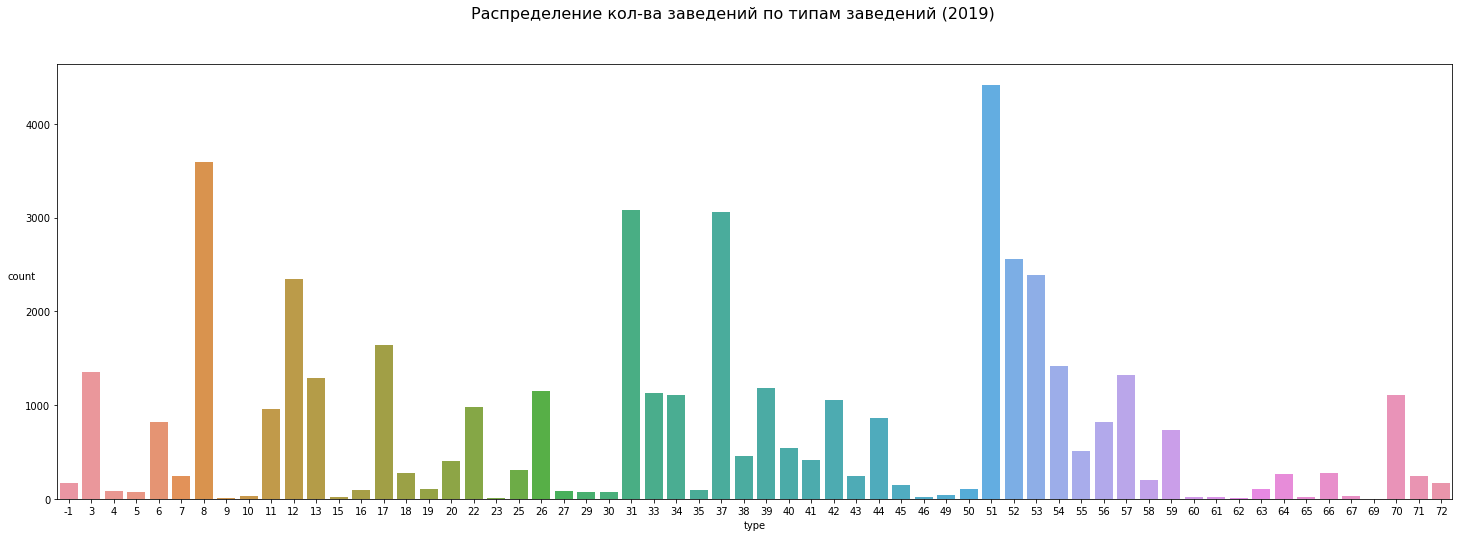

In [119]:
fig, ax = plt.subplots(1,1, figsize=(25,8))
fig.suptitle('Распределение кол-ва заведений по типам заведений (2019)', fontsize=16)
fig = places_19_groupby_type = places_19_df.groupby('type')['id'].count().reset_index()

ax = sns.barplot(x='type', y='id', data=places_19_groupby_type, ax=ax)
ax.set_ylabel('count', rotation=0)

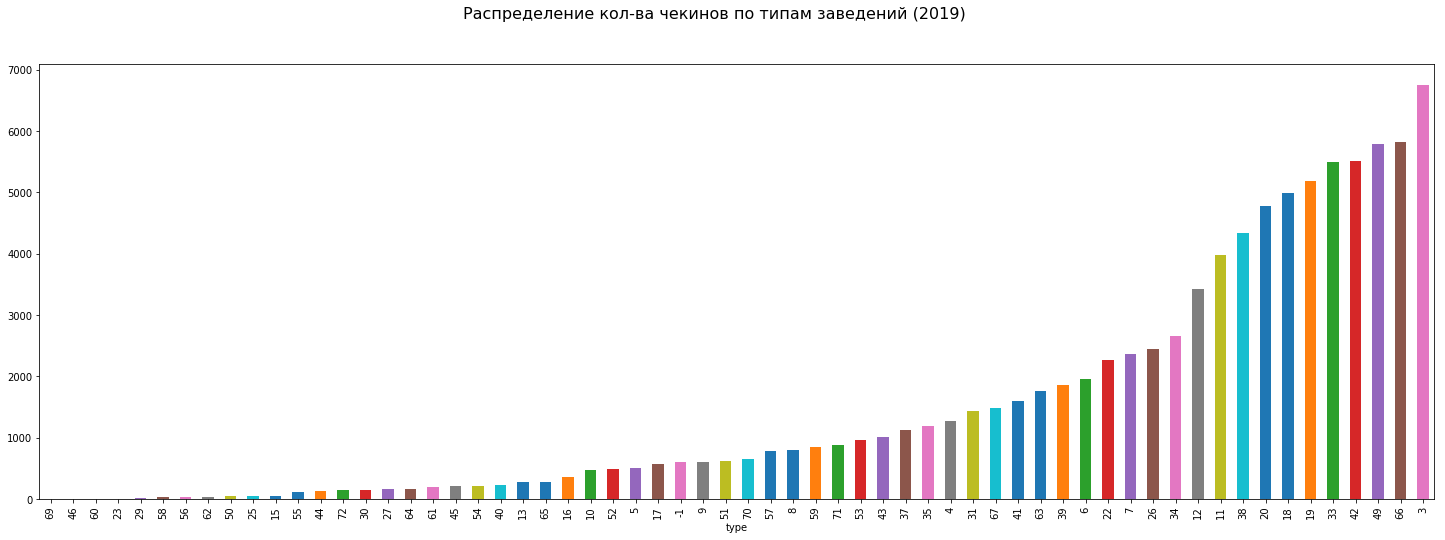

In [150]:
fig, ax = plt.subplots(1,1, figsize=(25,8))
fig.suptitle('Распределение кол-ва чекинов по типам заведений (2019)', fontsize=16)
places_19_groupby_type = places_19_df.groupby('type')['checkins'].sum().reset_index().sort_values('checkins').set_index('type')['checkins'].plot(kind='bar',ax=ax)

In [181]:
places_19_df[places_19_df['type']==4]

,Unnamed: 0,address,checkins,city,country,created,distance,id,lat,lng,title,type
13,13,"""площадь Конституции, 2""",6,2,1,1530209913,763,102221565,59.853726,30.303116,"""Jagger""",4
23,23,"""Новоизмайловский проспект, 49 к2""",1,2,1,1530210309,578,105698534,59.859511,30.303898,"""Банкетный комплекс ""Звезда""""",4
1375,1375,"""Московский проспект, 111""",35,2,1,1530209958,1036,102623012,59.888853,30.318951,"""Папанин""",4
1899,1899,"""Обводного Канала наб., 118""",41,2,1,1530210654,510,108654983,59.908101,30.307352,"""ZAL""",4
2023,2023,"""набережная Обводного канала, 181""",48,2,1,1530210873,251,110487500,59.909414,30.294041,"""Концерт-клуб Опера""",4
2429,2429,"""Бронницкая ул., 24""",117,2,1,1530209939,400,102454982,59.913978,30.323925,"""Космонавт""",4
3902,3902,"""Петергофское шоссе, 3 к1""",0,2,1,1530210774,327,109667750,59.847494,30.205537,"""Барский""",4
3905,3905,"""Петергофское шоссе, 3 к3""",1,2,1,1530210213,407,104869677,59.847176,30.207348,"""Нар Шараб""",4
3991,3991,"""Ленинский проспект, 93 к1""",6,2,1,1530210631,926,108458271,59.853790,30.210355,"""LenOn""",4
4930,4930,"""Восточный проезд, 13""",0,12,1,1530211861,1674,117762035,59.737200,30.453477,"""Music Pab""",4


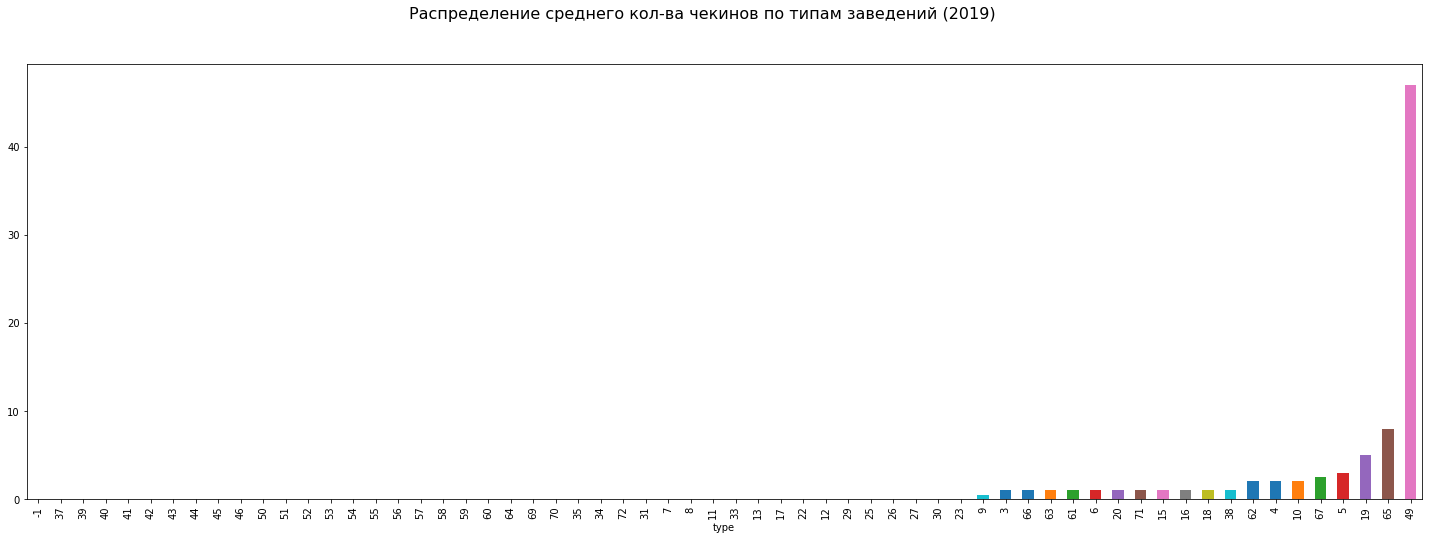

In [176]:
fig, ax = plt.subplots(1,1, figsize=(25,8))
fig.suptitle('Распределение среднего кол-ва чекинов по типам заведений (2019)', fontsize=16)
places_19_groupby_type = places_19_df.groupby('type')['checkins'].median().reset_index().sort_values('checkins').set_index('type')['checkins'].plot(x='type', kind='bar',ax=ax)

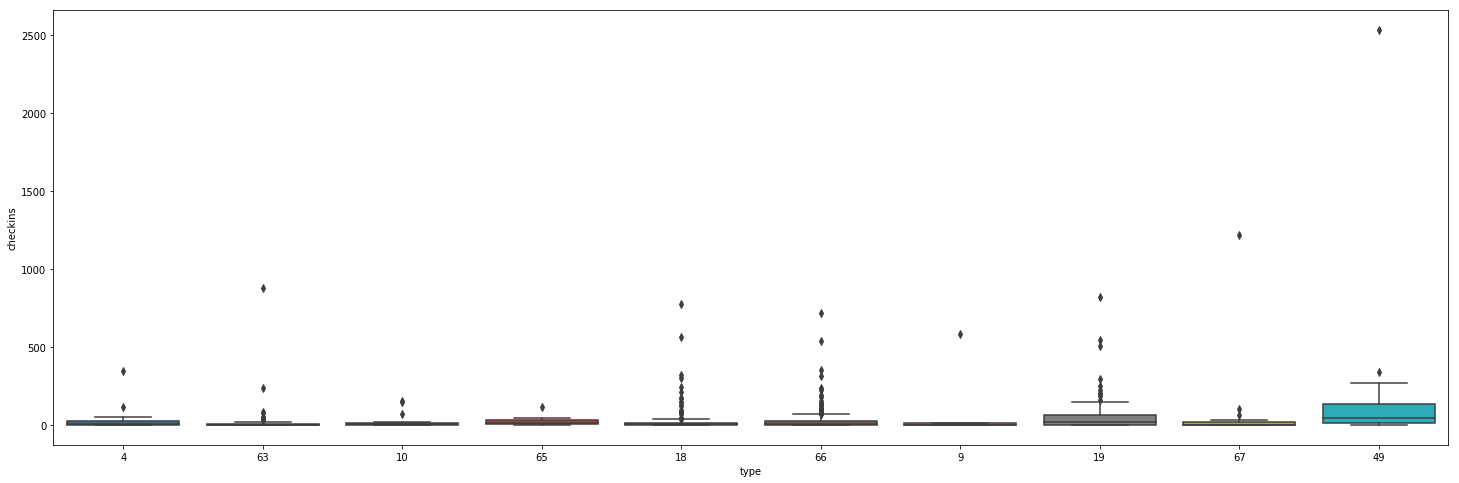

In [27]:
fig, ax = plt.subplots(1,1, figsize=(25,8))
temp_df = places_19_df[places_19_df['type'].isin([49,67,19,9,66,18,65,10,63,4])]
order = temp_df.groupby('type')['checkins'].mean().sort_values().keys().tolist()
sns.boxplot(x="type", y="checkins", data=temp_df[temp_df['checkins']>0], ax=ax, order=order)

# Чекины

In [31]:
#load data
checkins_18_df = pd.read_csv(raw_data + 'all_checkins.csv', encoding='windows-1251')
checkins_19_df = pd.read_csv(raw_data + checkins_out_file)

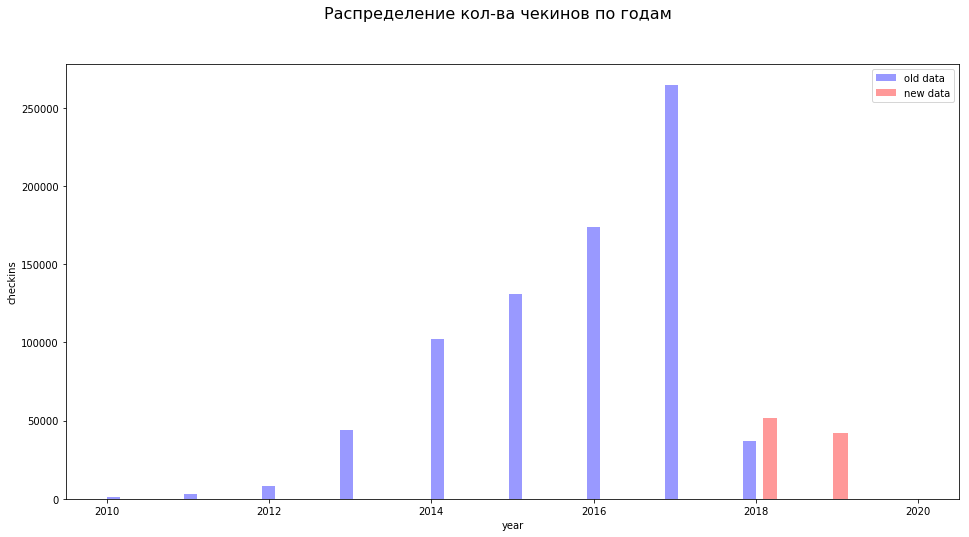

In [56]:
#распределение чекинов по годам
fig, ax = plt.subplots(1,1, figsize=(16,8))
fig.suptitle('Распределение кол-ва чекинов по годам', fontsize=16)

checkins_18_df['year'] = checkins_18_df.date.apply(lambda d: int(datetime.utcfromtimestamp(d).strftime('%Y')))
sns.distplot(checkins_18_df.year, kde=False, color='blue', label='old data')

checkins_19_df['year'] = checknis_19_df.date.apply(lambda d: int(datetime.utcfromtimestamp(d).strftime('%Y')))
ax = sns.distplot(checkins_19_df.year + 0.1, kde=False, color='red', hist_kws={'range': {2016,2020}}, label='new data')

ax.set_ylabel('checkins', rotation=90)

plt.legend()

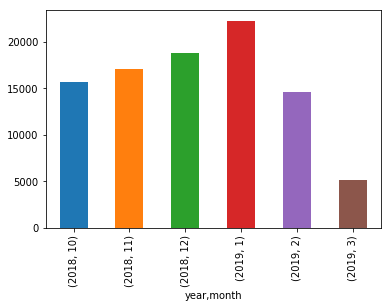

In [109]:
#распределение чекинов в течении года
checkins_19_df['month'] = checknis_19_df.date.apply(lambda d: int(datetime.utcfromtimestamp(d).strftime('%m')))
checkins_19_df.groupby([checkins_19_df['year'], checkins_19_df['month']])['post_id'].count().plot(kind='bar')

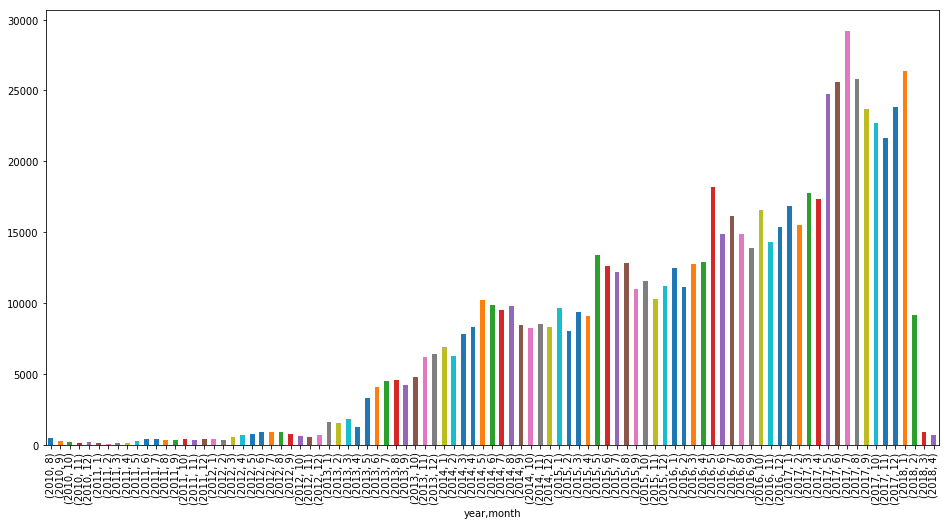

In [115]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
checkins_18_df['month'] = checknis_18_df.date.apply(lambda d: int(datetime.utcfromtimestamp(d).strftime('%m')))
checkins_18_df.groupby([checkins_18_df['year'], checkins_18_df['month']])['post_id'].count().plot(kind='bar')

In [138]:
df = pd.concat([checkins_18_df[['year','month','post_id']], checkins_19_df[['year', 'month', 'post_id']]])
df_append = pd.DataFrame([[2018,3,0], [2018,4,0],[2018,5,0],[2018,6,0],[2018,7,0],[2018,8,0],[2018,9,0]], columns=['year', 'month', 'post_id'])
df = df.append(df_append)

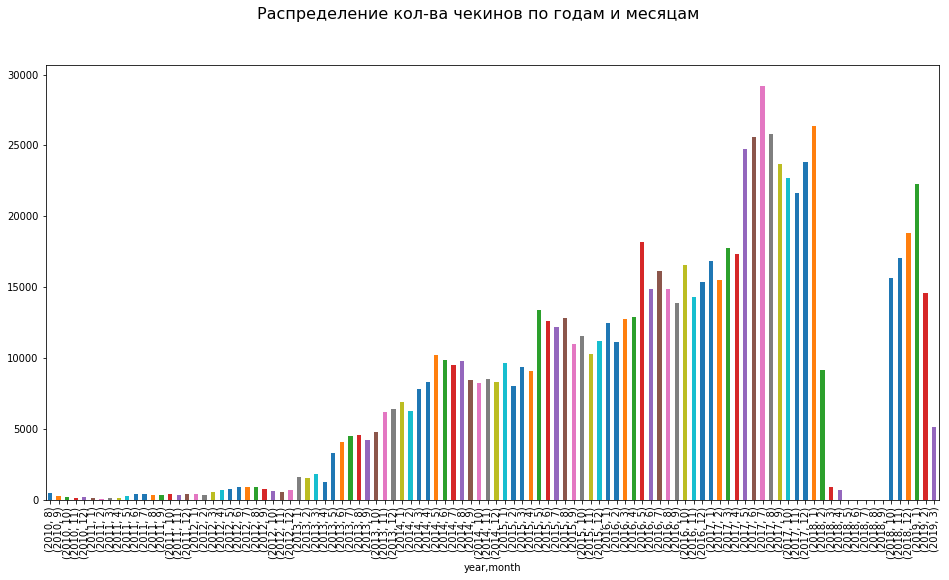

In [140]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
fig.suptitle('Распределение кол-ва чекинов по годам и месяцам', fontsize=16)
df.groupby([df['year'],df['month']])['post_id'].count().plot(kind='bar')

C:\Users\Artem\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


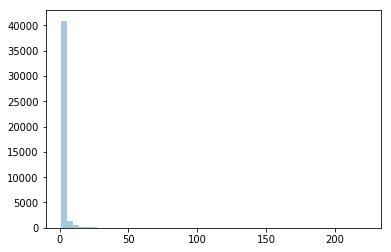

In [67]:

sns.distplot(checkins_19_df['user_id'].value_counts().tolist(),kde=False)

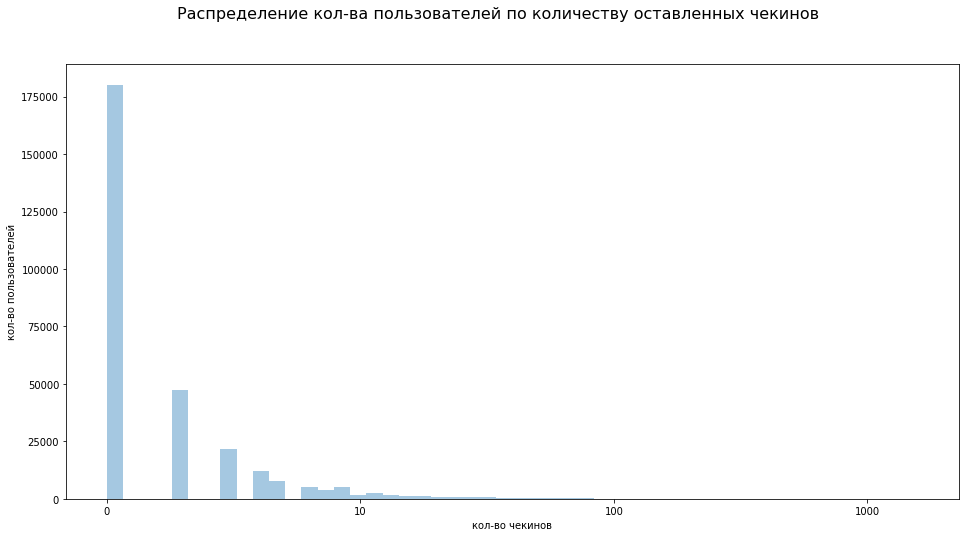

In [91]:
#распределение пользователей по количеству чекинов
fig, ax = plt.subplots(1,1, figsize=(16,8))
fig.suptitle('Распределение кол-ва пользователей по количеству оставленных чекинов', fontsize=16)
checkins_18_df = checkins_18_df.rename(index=str, columns={"uid":"user_id"})
df = pd.concat([checkins_18_df[['date','place_id','user_id','text']], checkins_19_df[['date','place_id','user_id', 'text']]])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels([0, 10, 100, 1000])
ax.set_xlabel('кол-во чекинов')
ax.set_ylabel('кол-во пользователей')
sns.distplot(list(map(lambda x: math.log(x,10), df['user_id'].value_counts().tolist())), kde=False, ax=ax)

In [92]:
places_19_df.head()

,Unnamed: 0,address,checkins,city,country,created,distance,id,lat,lng,title,type
0,0,"""Краснопутиловская улица, 50""",0,2,1,1530210942,98,111071337,59.858092,30.294984,"""Славянский базар""",34
1,1,"""Краснопутиловская улица, 50""",0,2,1,1530210724,104,109244241,59.858074,30.295102,"""Юпитер""",37
2,2,"""""",15,2,1,1530211939,787,118414262,59.865670,30.296047,"""парк Авиаторов""",20
3,3,"""Ленинский проспект, 148""",12,2,1,1530210124,701,104104001,59.852379,30.293774,"""Багратион Холл""",3
4,4,"""Кубинская улица, 44""",0,2,1,1530210357,225,106110421,59.860098,30.296579,"""Продукты""",51


In [93]:
places_18_df.head()

,Unnamed: 0,Unnamed: 0.1,address,checkins,city,country,created,distance,group_id,group_photo,icon,latitude,longitude,pid,place_id,title,type,updated
0,2,2,NaN,30,NaN,NaN,1454779254,252,NaN,NaN,https://vk.com/images/places/place.png,59.813872,30.132523,14087516,14087516,Курорт игора,21,1.516804e+09
1,8,8,улица Летчика Пилютова 54к1,4,NaN,NaN,1399823923,302,NaN,NaN,https://vk.com/images/places/place.png,59.826039,30.140337,8505920,8505920,Родительский дом!,21,1.463242e+09
2,12,12,улица Летчика Пилютова 54к1,12,NaN,NaN,1387448261,289,NaN,NaN,https://vk.com/images/places/place.png,59.827163,30.140394,7229933,7229933,Ул летчика пилютова 50,21,1.512333e+09
3,13,13,"улица Хлопина, 13",4,NaN,NaN,1485938203,302,NaN,NaN,https://vk.com/images/places/place.png,59.827108,30.140637,17302260,17302260,улица Летчика Пилютова 50-3,21,1.515361e+09
4,15,15,"Летчика Пилютова ул. 50 -3, КЕРАТИНОВОЕ ВЫПРЯМ...",4,2.0,1.0,1495614832,307,88943297.0,https://pp.userapi.com/c638723/v638723630/6414...,https://vk.com/images/places/place.png,59.827080,30.140723,13267460,13267460,SIDERIUS STUDIO?СЛОЖНОЕ ОКРАШИВАНИЕ.СПБ.пр.Ветер,21,1.513887e+09


In [96]:
#попытаемя объеденить две базы
#ключевые поля(Название, координаты)
places_18_df = places_18_df.rename(index=str, columns={"latitude":"lat", "longitude":"lng"})
merge_df = pd.merge(places_19_df, places_18_df, how='inner', on=['lat','lng'] )

In [100]:
merge_df.shape

(117, 28)

In [ ]:
#Получить чекины пользователей у которых больше 10 чекинов
uid_counts = pd.DataFrame({'count':checkins_df.groupby('uid').size()}).reset_index()
user_list = uid_counts[uid_counts['count'] > 10].uid.tolist()
checkins_df[checkins_df.uid.isin(user_list)].to_csv('../Data/ProcessingData/chekins.csv')

In [ ]:
#Получить заведения с количеством чекинов больше 30 и в которых чекинились люди с большим количеством чекинов
place_list = checkins_df[checkins_df.uid.isin(user_list)].drop_duplicates('place_id')['place_id'].tolist()
places = places_df[places_df.place_id.isin(place_list)]
places = places[places.checkins > 20]
places.to_csv('../Data/ProcessingData/places.csv')

In [ ]:
coords = pd.read_csv('../Data/ProcessingData/places_coords.csv',';', encoding='utf-8')

In [ ]:
geocoded_places = pd.merge(places, coords, how='left', on='address')

In [ ]:
geocoded_places = geocoded_places.drop_duplicates('pid')

In [ ]:
geocoded_places = geocoded_places[geocoded_places.geocodetype.isin(['exact', 'number', 'near'])]

In [ ]:
geocoded_places.to_csv('../Data/ProcessingData/geocoded_places.csv')

### Пользователи

In [7]:
checkins_df = pd.read_csv(raw_data + checkins_out_file)
checkins_df.head(1)

,Unnamed: 0,date,id,latitude,longitude,place_id,post_id,text,user_id
0,0,1551453012,17,0.0,0.0,118414262,3662,NaN,200670


In [8]:
uniq_users_ids = checkins_df.drop_duplicates('user_id')['user_id'].tolist()
len(uniq_users_ids)

43403

In [19]:
def get_users_info(users_ids_list):
    users_info = []
    
    max_ids_count = 1000
    q_fields = "sex, bdate, city, country, home_town, has_photo, domain, has_mobile, contacts, site, education, universities, schools, status, last_seen, followers_count, common_count, occupation, nickname, relatives, relation, personal, connections, exports, activities, interests, music, movies, tv, books, games, about, quotes, can_post, can_see_all_posts, can_see_audio, can_write_private_message, can_send_friend_request, is_favorite, is_hidden_from_feed, timezone, screen_name, maiden_name, crop_photo, is_friend, friend_status, career, military, blacklisted, blacklisted_by_me"
    iterration_count = len(users_ids_list)/int(max_ids_count)
    for i in range(0, int(iterration_count)):
        list_start = int(max_ids_count * i)
        list_end = int(max_ids_count * (i+1))
        while True:
            try:
                users = vk_api.users.get(user_ids=users_ids_list[list_start:list_end], fields=q_fields)
                users_info.extend(users)
                time.sleep(0.33)
            except Exception as e:
                print(e)
                time.sleep(0.33)
                continue
            else:
                break
                
    return users_info

In [20]:
users_info = get_users_info(uniq_users_ids)

In [22]:
users_df = pd.DataFrame(users_info)
users_df.to_csv(raw_data + "users.csv")

### Матрица пользователей

In [6]:
# список друзей
users_df = pd.read_csv(raw_data + "users.csv")
users_df.head(1)

C:\Users\Artem\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4,5,7,8,9,10,11,14,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,about,activities,bdate,blacklisted,blacklisted_by_me,books,can_post,can_see_all_posts,can_see_audio,can_send_friend_request,can_write_private_message,career,city,common_count,country,crop_photo,deactivated,domain,education_form,education_status,facebook,facebook_name,faculty,faculty_name,first_name,followers_count,friend_status,games,graduation,has_mobile,has_photo,home_phone,home_town,id,instagram,interests,is_favorite,is_friend,is_hidden_from_feed,last_name,last_seen,livejournal,maiden_name,mobile_phone,movies,music,nickname,occupation,personal,quotes,relation,relation_partner,relatives,schools,screen_name,sex,site,skype,status,status_audio,tv,twitter,universities,university,university_name
0,0.0,NaN,NaN,23.3.1989,0,0,NaN,0,0,1,1,0,NaN,"{'id': 2, 'title': 'Санкт-Петербург'}",0,"{'id': 1, 'title': 'Россия'}","{'photo': {'id': 456242327, 'album_id': -6, 'o...",NaN,id200670,NaN,NaN,NaN,NaN,NaN,NaN,Света,292.0,0.0,NaN,NaN,1.0,1.0,NaN,NaN,200670.0,kochkina888,NaN,0.0,0.0,0.0,Кочкина,"{'time': 1553693779, 'platform': 2}",NaN,Костикова,NaN,NaN,NaN,NaN,"{'type': 'university', 'id': 50, 'name': 'ИНЖЭ...",NaN,NaN,NaN,NaN,NaN,NaN,id200670,1.0,http://taplink.cc/kochkina888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
users_df = users_df.dropna(subset=['id'])

In [18]:
users_id_set = set(users_df['id'].apply(int).tolist())